In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #svg
import pylab as plb
import numpy as np
import scipy as sp
import flylib as flb
import group_data as gd
plb.rcParams['pdf.fonttype'] = 42 #allows text in saved .pdf files to be edited in illustrator
plb.rcParams['image.interpolation'] = 'Nearest'
plb.rcParams['image.cmap'] = 'BrBG'
recalc_means = False #recalculate the groupwise mean stats. Set to False to load from file
demo_mode = False
import warnings
warnings.filterwarnings('ignore')

In [3]:
import h5py
trial_db = h5py.File('../02_imaging_post_processing/trial_db.hdf5','r')

In [4]:
trial_types = set(trial_db['trial_names'])
test_set = list(trial_types.difference(['flight_starts','flight_stops','stripe_fix']))
fly_set_22H05_rot = set(gd.GMR22H05_yr_list).union(set(gd.GMR22H05_pr_list))
#set(gd.GMR22H05_pr_list)
#fly_set_39E01 = set(gd.GMR39E01_list)

In [5]:
#mask out the data so only the trial types in test_set will be included we dont want to look
#at stripe fixation, or flight initataion or termination events
trial_mask = np.zeros(np.shape(trial_db['trial_names'])[0]).astype(bool)
for trial_name in test_set:
    trial_mask |= (np.array(trial_db['trial_names']) == trial_name)

#now mask out the data to only include the flys in gd.GRM22H05_list
fly_mask_22H05_rot = np.zeros_like(trial_mask,dtype = bool)
for fly in fly_set_22H05_rot:
    fly_mask_22H05_rot |= (np.array(trial_db['fly_numbers']) == fly)

#update the mask    
mask_22H05_rot = trial_mask & fly_mask_22H05_rot

time_mask = gd.get_xio('pth_roll_0')<10
trial_samples = np.sum(time_mask)
# Create a selection array to include only epochs with flight for for the entire trial - i.e. the number of samples
# with a wing-beat frequency > 100  was equal to the number of samples in the trial
flt_selection = np.nansum(np.array(trial_db['wb_frequency']) > 100,axis = 1)>=trial_samples
mask_22H05_rot &=  flt_selection

In [6]:
import os
os.remove('open_loop_rotation_22H05.hdf5')

In [7]:
mtd = h5py.File('open_loop_rotation_22H05.hdf5','a')

In [8]:
def get_norm_term(signal,mask = mask_22H05_rot,xi_range = (-3,0),xio_trial_name = 'pth_roll_0'):
    """get the norm and mean value over the samples in the time range xi_range 
    for the data in the matrix 'signals' with rows selected by mask. trial_name is
    used to determine the mapping from samples to times in xi_range"""
    data_selection = trial_db[signal][mask,:]
    xi = gd.get_xio(trial_name)
    baseline_mask = (xi>xi_range[0]) & (xi<[xi_range[1]]) 
    mean_val = np.nanmean(data_selection[:,baseline_mask])#,axis = 1)[:,np.newaxis]
    subtracted_selection = data_selection-mean_val
    return np.nanstd(subtracted_selection[:,baseline_mask]),mean_val

In [9]:
#create dictionary to store the normalization values
signal_norms_22H05 = dict()
signal_means_22H05 = dict()
#the signal norms will be computed for the 'matrix' like signals, init with a blank selection mask
[signal_norms_22H05.update({signame:np.zeros_like(mask_22H05_rot)}) for signame,dset in trial_db.items() if (np.ndim(dset)>1)];
[signal_means_22H05.update({signame:np.zeros_like(mask_22H05_rot)}) for signame,dset in trial_db.items() if (np.ndim(dset)>1)];
#create a vector of norm values for each trial
for fly in fly_set_22H05_rot: #loop over all the flies in fly_set
    fly_selection_mask = np.array(trial_db['fly_numbers']) == fly #create a selection mask for the fly
    for nor,mea in zip(signal_norms_22H05.items(),signal_means_22H05.items()): #loop over all the signals
        sig_key = nor[0]
        norm_array = nor[1]
        mean_array = mea[1]
        norm_val,mean_val = get_norm_term(sig_key,mask = fly_selection_mask,xio_trial_name = 'pth_roll_0')
        if ~np.isfinite(norm_val):
            norm_val = 0
        if ~np.isfinite(mean_val):
            mean_val = 0
        signal_norms_22H05[sig_key] = norm_array + (fly_selection_mask*norm_val) #add in the normalization values
        signal_means_22H05[sig_key] = mean_array + (fly_selection_mask*mean_val)

In [10]:
#dataset to hold the normalized data
mtd.create_group('normed_signals')
#also save a copy of the untransformed data 
mtd.create_group('selected_signals')

<HDF5 group "/selected_signals" (0 members)>

In [11]:
for k in signal_norms_22H05.keys():
    ssig = trial_db[k][mask_22H05_rot,:]
    flb.update_dset(mtd['selected_signals'],k,ssig)
    xi = gd.get_xio('pth_roll_0')
    baseline_idx = xi<0
    nsig = (ssig - signal_means_22H05[k][mask_22H05_rot][:,np.newaxis])/signal_norms_22H05[k][mask_22H05_rot][:,np.newaxis]
    flb.update_dset(mtd['normed_signals'],k,nsig)

In [12]:
#now apply the masked selection to the trial description vectors and store
for key,dset in trial_db.items():
    if (np.ndim(dset)<2):
        if not(key == u'signal_units'):
            flb.update_dset(mtd['selected_signals'],key,dset[mask_22H05_rot])

In [13]:
#use the left-right amplitude (Ph2) as the sort index
stim_ep = (0,3)
sig = np.array(mtd['normed_signals']['Ph2'])
sort_idx = np.argsort(np.mean(sig[:,(xi>stim_ep[0]) & (xi<stim_ep[1])],axis = 1))[::-1] #reverse ordered
flb.update_dset(mtd,'sort_idx',sort_idx)

In [14]:
for key,value in mtd['normed_signals'].items():
    mtd['normed_signals'][key][:] = np.array(mtd['normed_signals'][key])[mtd['sort_idx']]
for key,value in mtd['selected_signals'].items():
    mtd['selected_signals'][key][:] = np.array(mtd['selected_signals'][key])[mtd['sort_idx']]

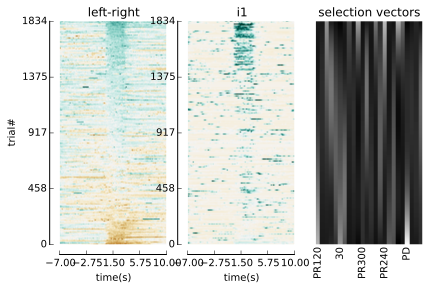

In [15]:
#Check to see if trials are sorted correctly and examine
# how the trial types are co-sorted by lmr response
reload(gd)
import plotfuncs as plf
xi = gd.get_xio('pth_roll_0')
plb.figure(figsize = (6.5,4))

plb.subplot(1,3,1)
shp = np.shape(mtd['normed_signals']['Ph2'])
plb.imshow(mtd['normed_signals']['Ph2'],
           aspect = 'auto',
           vmin = -6,vmax = 6,
           extent = (xi[0],xi[-1],0,shp[0]))
plb.gca().set_xbound(-7,10)
plf.pull_ax_spines(xtick_numbers = 5)
bnds = plb.gca().get_ybound()
plb.gca().set_yticklabels(np.linspace(0,bnds[-1],5,dtype = int));
plb.gca().set_xlabel('time(s)')
plb.gca().set_ylabel('trial#')
plb.gca().set_title('left-right')

plb.subplot(1,3,2)
shp = np.shape(mtd['normed_signals']['i1'])
plb.imshow(mtd['normed_signals']['i1'],
           aspect = 'auto',
           vmin = -6,vmax = 6,
           extent = (xi[0],xi[-1],0,shp[0]))
plb.gca().set_xbound(-7,10)
plf.pull_ax_spines(xtick_numbers = 5)
bnds = plb.gca().get_ybound()
plb.gca().set_yticklabels(np.linspace(0,bnds[-1],5,dtype = int));
plb.gca().set_xlabel('time(s)')
plb.gca().set_title('i1')

trial_list = list(set(mtd['selected_signals']['trial_names']))

def smooth_inter_fun(r):
    from scipy import interpolate
    s = interpolate.UnivariateSpline(np.arange(len(r)), r)
    s.set_smoothing_factor(120)
    xnew = np.arange(0, len(r)-1, .1)
    return s(xnew)

trial_mtrx = [smooth_inter_fun((np.array(mtd['selected_signals']['trial_names']) == sig)) for sig in trial_list]
plb.subplot(1,3,3)
plb.imshow(np.array(trial_mtrx).T[::-1],aspect = 'auto',cmap = plb.cm.gray)
plf.kill_spines()
trial_list = [gd.trial_to_label[tr] for tr in trial_list]
trial_list = [None] + trial_list
plb.gca().set_xticklabels(trial_list,rotation = 90)
[x.set_visible(True) for x in plb.gca().get_xticklabels()]

plb.gca().get_xaxis().majorTicks[1].label1.set_horizontalalignment('center')
plb.gca().set_title('selection vectors')

In [17]:
trial_db.close()
mtd.flush()
mtd.close()